## E18. OCR
OCR(Optical Character Recognition, 광학 문자 인식)은 문자를 읽는 기술로 현재 다양한 분야에서 유용하게 쓰이고 있는 기술이다. 딥러닝이 도입된 이후 OCR 기술이 획기적으로 개선되어 현실에서 더욱 유용하게 쓰이고 있다. OCR은 두 단계를 거친다 - 1) detection(인식), 2) recognition(해독). 이미지에서 문자를 먼저 인식하고, 찾아낸 문자를 해독한다.    

여기서는 세가지의 ocr 기술을 배워보고, 관련된 프로젝트를 수행할 것이다.        
* Google OCR API 
* Keras-OCR
* Google Tesseract 

### Google OCR API

In [7]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [8]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l$GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 436
-rw-r--r-- 1 root root 445061 Sep 19 12:44 Untitled.ipynb
Texts:

"ACCOUNT STATEMENT
SAND FLAT WATER SUPPLY CORP.
14874 FM 14
ACCOUNT NUMBER
DUE DATE
AMOUNT DUE
TYLER, TX 75706
00099999
10/15/2015
$162.87
AMOUNT DUE IF PAID AFTER 10/15/2015
$167.87
ACCOUNT NAME:
SUSAN D WALKER
SINGLE-PIECE I SGL 103AA2-A-
I SP 0.480
SERVICE ADDRESS:
12345 ANYSTREET DRIVE
SERVICE PERIOD:
08/28/2015 TO 09/29/2015
BILLING DATE:
10/01/2014
BILLING DAYS:
32
SUSAN D SAMPLE
12345 ANYSTREET DRIVE
QUESTIONS ABOUT YOUR BILL?
Office Hours:
Office Phone: (903) 526-5243
Website:
Monday to Friday, 8:30 a.m. to 4:00 p.m.
Office Fax: (903) 526-5245
www.sandflatwater.com
www.iwebms.net/sandflatwater
1 (844) 798-3448
TYLER TX 75706-4932
Online Bill Pay:
Pay by Phone Toll-Free:
CURRENT METER USAGE
Meter
Previous
Current
Usage
67341736
889700
900800
USAGE HISTORY (IN GALLONS)
11100
12000
placeholder
12744
12756
40
ACCOUNT SUMMARY
LAST BILL
$95.84
$0.00
$0.00
$95.84
30
TOTAL PAID SINCE LAST BILL
20
ADJUSTMENTS
PA

### Keras-ocr

Keras에서 ocr detector와 recognizer 모델 다운받기 

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


테스트에 사용할 이미지 url을 모아 보자

In [2]:
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

테스트 이미지 시각화 

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


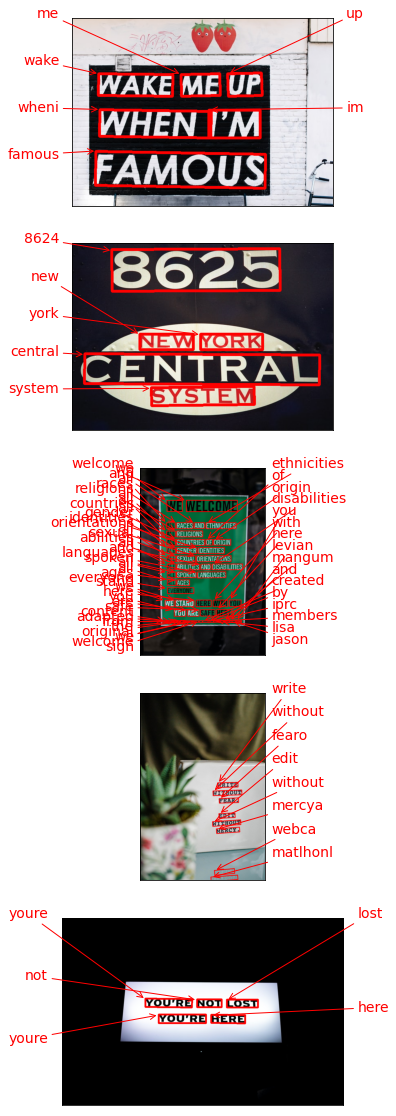

In [3]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Google's Tesseract OCR
아래에서 구현한 crop_word_regions() 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.

기본적으로 pytesseract.image_to_data() 를 사용. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 됨. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 된다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였다.

In [ ]:
#설치가 안 되어 있다면 아래의 코드로 설치. 
# pip install pytesseract 

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

output_dir = os.getenv('HOME')+'/aiffel/Exploration/E18/test'
img_file_path = os.getenv('HOME')+'/aiffel/Exploration/E18/image 2.jfif'   

cropped_image_path_list = crop_word_regions(img_file_path, output_dir)

/aiffel/aiffel/Exploration/E18/test/0000.png


In [ ]:
# 한국어 인식을 위해서는 다음을 설치해줘야 한다. 
# sudo apt install tesseract-ocr-kor

In [9]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


### 프로젝트 
* 프로젝트 목표: 간판을 감지, 문자화 해서 시각장애인들에게 전달할 수 있다면 길을 찾고, 장소를 찾는데 큰 도움이 될 수 있을것 같다.  
* 평가기준: 간판의 글씨를 감지해서 정확하게 한글, 영문을 읽어내는 능력을 기준으로 평가할 것이다. 

### Step 1. 검증용 데이터셋 준비 
https://github.com/hyunnie94/AIFFEL/blob/master/E18_OCR

위의 사이트에서 한글 및 영어로 된 간판 데이터셋을 9개 다운받았다. 

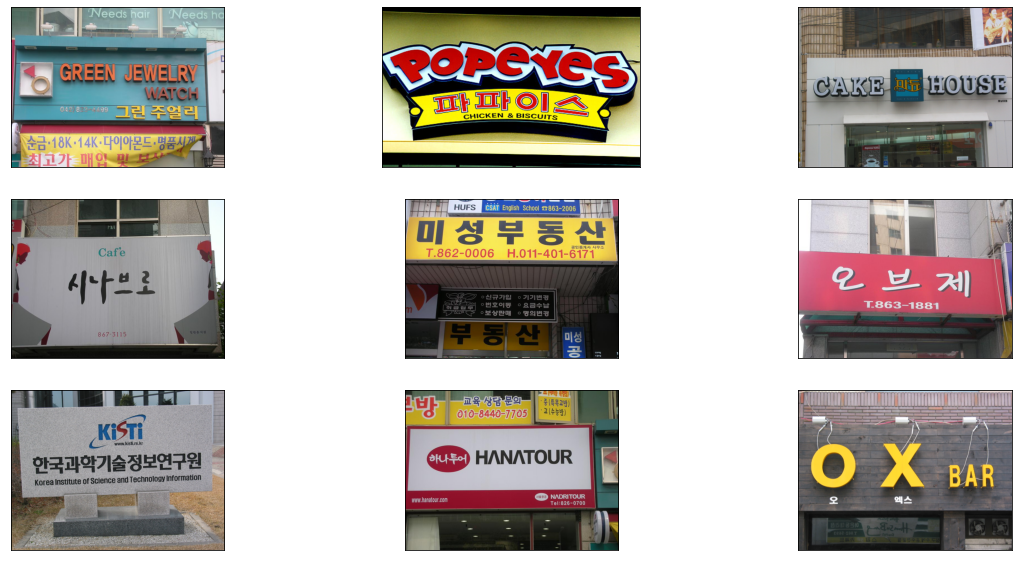

In [1]:
import cv2
import os
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 3
i = 1

dir_path = os.getenv('HOME')+'/aiffel/Exploration/E18/'
imgPaths = [dir_path +'image 1.jfif', dir_path +'image 2.jfif', dir_path +'image 3.jfif', dir_path +'image 4.jfif', 
            dir_path +'image 5.jfif', dir_path +'image 6.jfif', dir_path +'image 7.jfif', dir_path +'image 8.jfif',
            dir_path +'image 9.jfif']

for img in imgPaths:
    img = cv2.imread(img)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1

plt.show()

### Step 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행 

#### Google ocr api
성능이 꽤 좋은 편이다. 
1. 그린 주얼리  - 작은 글씨도 정확히 맞추었다. 
2. popeyes - 영어를 완벽하게 인식하지 못했다. 
3. cafe house - 중간에 있는 한글빼고 잘 인식했다. 
4. cafe 시나브로  - 잘 인식했다. 
5. 미성부동산 - 꽤 정확히 인식했다. 
6. 오브제 - 한글 간판인데도 꽤 정확히 인식했다. 
7. 과기원 - 정확히 인식했다. 
8. 하나투어 - 정확히 인식
9. ox bar - 정확히 인식

In [11]:
for path in imgPaths:
    detect_text(path)

Texts:

"Needs hair
Needs ha
GREEN JEWELRY
WATCH
그린 주얼리
042) 823-4499
순금·18K-14K·다이아몬드·명품시
최고가 매입 및 보사
"

"Needs"

"hair"

"Needs"

"ha"

"GREEN"

"JEWELRY"

"WATCH"

"그린"

"주얼리"

"042)"

"823-4499"

"순금"

"·"

"18K"

"-"

"14K"

"·"

"다이아몬드"

"·"

"명품"

"시"

"최고가"

"매입"

"및"

"보사"
bounds: (480,518),(544,517),(545,573),(481,574)
Texts:

"POPCYES
R
CHICKEN & BISCUITS
"

"POPCYES"

"R"

"CHICKEN"

"&"

"BISCUITS"
bounds: (257,195),(320,195),(320,205),(257,205)
Texts:

"CAKE HOUSE
STADIU
Cake .dh
Espresse Comee
"

"CAKE"

"HOUSE"

"STADIU"

"Cake"

".dh"

"Espresse"

"Comee"
bounds: (227,420),(244,420),(244,426),(227,426)
Texts:

"Cafe
시나브로
일반음식점
867-3115
"

"Cafe"

"시나브로"

"일반"

"음식점"

"867-3115"
bounds: (313,483),(412,482),(412,497),(313,498)
Texts:

"HUFS
CSAT English School 863-2006
미성부동산
공인중개사 사무소
T.862-0006 H.011-401-6171
ㅇ신규가입
으 기기변경
o 요금수납
ㅇ보상판매 0 명의변경
ㅇ 번호이동
m
취금업무
부동산
미성
공
친규기업
"

"HUFS"

"CSAT"

"English"

"School"

"863-2006"

"미성"

"부동산"

"공인중개사"

"사무소"

"T.862-0006"

"H.011-

#### keras-ocr
한글은 전혀 인식하지 못한다. Google api와 마친가지로 popeyes를 제대로 인식하지 못했다.  

In [17]:
images = [ keras_ocr.tools.read(img) for img in imgPaths]
prediction_groups = [pipeline.recognize([img]) for img in imgPaths]

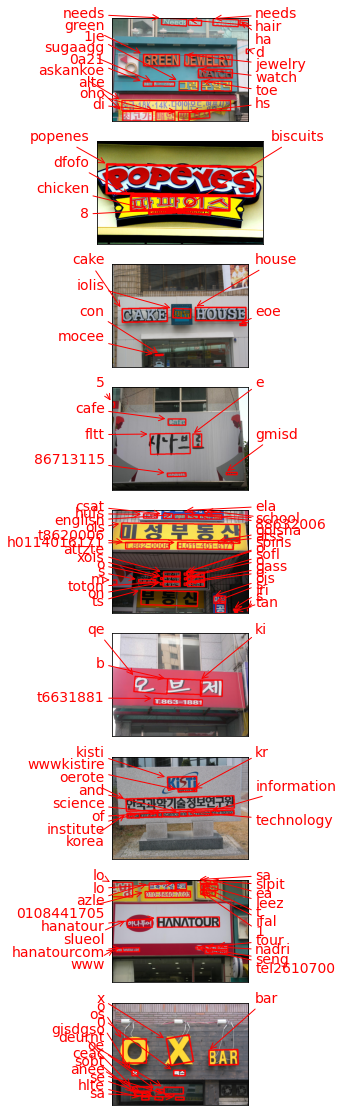

In [19]:
fig, axs = plt.subplots(nrows=len(images), figsize=(30, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract 
1. 첫번째 사진은 에러가 나서 작동이 안되서 두번쨰 사진부터 적용했다. 
2. 영어를 적용했을때는 성능이 매우 안 좋아서 거의 아무 단어도 찾아내지 못했다. 
3. 'crop_word_regions' 함수에 한국어를 적용해 봤다. 그래도 성능은 크게 나아지지 못했다. 

In [19]:
output_dir_ocr = os.getenv('HOME')+'/aiffel/Exploration/E18/tesseract_output'

cropped_image_path_list2 = crop_word_regions(dir_path + 'image 2.jfif', output_dir_ocr + '/2')
cropped_image_path_list3 = crop_word_regions(dir_path + 'image 3.jfif', output_dir_ocr + '/3')
cropped_image_path_list4 = crop_word_regions(dir_path + 'image 4.jfif', output_dir_ocr + '/4')
cropped_image_path_list5 = crop_word_regions(dir_path + 'image 5.jfif', output_dir_ocr + '/5')
cropped_image_path_list6 = crop_word_regions(dir_path + 'image 6.jfif', output_dir_ocr + '/6')
cropped_image_path_list7 = crop_word_regions(dir_path + 'image 7.jfif', output_dir_ocr + '/7')

/aiffel/aiffel/Exploration/E18/tesseract_output/2/0000.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0000.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0001.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0002.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0003.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0004.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0005.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0006.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0007.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0008.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0009.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0010.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0011.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0012.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0013.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0014.png
/aiffel/aiffel/Exploration/E18/tesseract_output/3/0015.p

In [20]:
print(recognize_images(cropped_image_path_list2))
print(recognize_images(cropped_image_path_list3))
print(recognize_images(cropped_image_path_list4))
print(recognize_images(cropped_image_path_list5))
print(recognize_images(cropped_image_path_list6))
print(recognize_images(cropped_image_path_list7))


Done
None
——_——<i‘isOsS



Th

OO ee



——————— == SS) 6S SS 6 CSS 6S [6S






lepRaaa

|

Pa 0t bm

ovens § fh 88 oe

PPria

ig

Beceeeeeaee

ea

yu

my tt


UG

*(9171 S12

Es

Done
None

Done
None

fat

Ol

—

iI-0

|

So

it

a ane

eee

E

Ms

HUFS

GSAT Enalish Sc

noo! 2863-20

ue

7

aaa.

E

eS. ae

1.862


-QOO06


011-401-

}

47 4

eve BoE

Done
None

Done
None
7 |

ees

at ikl

Se

Kisti

Of WON |S

AHO Ts

ore

a Institute

of

Science

and

Technolog

vy information

eel



Done
None


#### 한국어 tesseract-ocr 설치, 작동

In [24]:
def crop_word_regions_ko(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [25]:
output_dir_ocr = os.getenv('HOME')+'/aiffel/Exploration/E18/tesseract_output/korean'

cropped_image_path_list2_ko = crop_word_regions_ko(dir_path + 'image 2.jfif', output_dir_ocr + '/2')
cropped_image_path_list3_ko = crop_word_regions_ko(dir_path + 'image 3.jfif', output_dir_ocr + '/3')
cropped_image_path_list4_ko = crop_word_regions_ko(dir_path + 'image 4.jfif', output_dir_ocr + '/4')
cropped_image_path_list5_ko = crop_word_regions_ko(dir_path + 'image 5.jfif', output_dir_ocr + '/5')
cropped_image_path_list6_ko = crop_word_regions_ko(dir_path + 'image 6.jfif', output_dir_ocr + '/6')
cropped_image_path_list7_ko = crop_word_regions_ko(dir_path + 'image 7.jfif', output_dir_ocr + '/7')

/aiffel/aiffel/Exploration/E18/tesseract_output/korean/2/0000.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0000.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0001.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0002.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0003.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0004.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0005.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0006.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0007.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0008.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0009.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0010.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0011.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0012.png
/aiffel/aiffel/Exploration/E18/tesseract_output/korean/3/0013.png
/aiffel/ai

In [26]:
print(recognize_images(cropped_image_path_list2_ko))
print(recognize_images(cropped_image_path_list3_ko))
print(recognize_images(cropped_image_path_list4_ko))
print(recognize_images(cropped_image_path_list5_ko))
print(recognize_images(cropped_image_path_list6_ko))
print(recognize_images(cropped_image_path_list7_ko))


Done
None
——_——<i‘isOsS



Th

OO ee



——————— == SS) 6S SS 6 CSS 6S [6S






lepRaaa

|

Pal Et bem

ait

oe 3a

ae

; |

gg

a

litt

tan

i eLEePLELLL

my tt


UG

“(Olu

(a

‘

Es

Done
None

Done
None

fat

Ol

—

iI-0

|

So

te

E

eee

E

\

ha

I

‘J

_

E

(ay VE

aie

School

3 603-2006

ii

rn


E


E

E

eS. ae

a

-QOO06


011-401-

}

47 4

eve BoE

Done
None

Done
None
jt

|

ein <

'

eas,

ein <

at ikl

Se

Kisti

Of

=

vt

OF

J


aS

i=

Of-17

Korea Institute

of Science

and Technology information

eel



Done
None


### Step 3. 테스트 결과 분석

* 앞에서 살펴보았듯이 Google OCR API는 다른 ocr에 비해서 성능이 뛰어나다. 한글, 영문 간판 둘다 글자 인식능력이 좋았다. 물론 완벽하진 않지만 바로 실생활에 적용해도 손색 없을정도의 성능이라고 생각된다. 전화번호와 같은 아주 작은 글씨도 사람의 육안보다 더 잘 읽어낸다.  
* Keras-ocr의 성능도 영문을 인식하는 면에서는 나쁘지 않았지만, 데이터셋의 많은 부분이 한글 간판이여서 한글을 읽는 능력은 거의 없다고 봐도 무방하다. 
* Tesseract는 앞에서 살펴보았듯이 영문, 한글 패캐지로 둘다 적용하였지만 간판을 읽어내는 능력은 많이 부족해 보인다. 

### 결론 및 회고 
실험결과 Google OCR API가  매우 좋은 성능을 보였다. 물론 프로젝트를 현실화 시키려면 더 많은 데이터 셋으로 실험을 해야 하겠지만 여기서 보여준 성능은 매우 긍정적이고 다음 실험에서도 비슷한 성능을 보인다면 프로젝트에 바로 적용해 볼 수 있을것 같다. 